# IBM Data Science Experience with PixieDust

### Analyze data and build a dashboard with Spark, notebooks, and PixieDust

Interactive notebooks are powerful tools for fast and flexible experimentation and data analysis. Notebooks can contain live code, static text, equations and visualizations. 

In this lab, we will walk through how to use PixieDust with Spark and notebooks to:
- Analyze open data around traffic accidents in San Francisco
- Build charts and maps to discover insights

We will then show how to:
- Build a dashboard that drills down into specific areas
- Combine multiple data sources like crime or speeding zones to extract even more insights  

![pixiedust](https://developer.ibm.com/clouddataservices/wp-content/uploads/sites/85/2017/03/pixiedust200.png)

Learn more about PixieDust [Here](https://www.ibm.com/analytics/us/en/watson-data-platform/pixiedust/).

This notebook runs on Python with Spark 2.x.

This Lab is based on the tutorial published with step by step instructions here: [https://www.slideshare.net/DTAIEB/pixie-dust-overview](https://www.slideshare.net/DTAIEB/pixie-dust-overview)

In [4]:
# Licensed under the Apache License, Version 2.0 (the "License"); you may
# not use this file except in compliance with the License. You may obtain
# a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS, WITHOUT
# WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the
# License for the specific language governing permissions and limitations
# under the License.

In [ ]:
#!pip install --upgrade bokeh==0.12.6

## 1. Procure PixieDust <a class="anchor" id="install"></a>
Note that Watson Studio Jupyter environment comes with a version of pixiedust already installed.  
In the next cell, we will import the `pixiedust` package 

In [2]:
# Before, you can use the PixieDust library it must be imported into the notebook.
# This notebook requires version 1.0.6
import pixiedust

Pixiedust database opened successfully
Table VERSION_TRACKER created successfully
Table METRICS_TRACKER created successfully

Share anonymous install statistics? (opt-out instructions)

PixieDust will record metadata on its environment the next time the package is installed or updated. The data is anonymized and aggregated to help plan for future releases, and records only the following values:

{
   "data_sent": currentDate,
   "runtime": "python",
   "application_version": currentPixiedustVersion,
   "space_id": nonIdentifyingUniqueId,
   "config": {
       "repository_id": "https://github.com/ibm-watson-data-lab/pixiedust",
       "target_runtimes": ["Data Science Experience"],
       "event_id": "web",
       "event_organizer": "dev-journeys"
   }
}
You can opt out by calling pixiedust.optOut() in a new cell.


Pixiedust runtime updated. Please restart kernel
Table SPARK_PACKAGES created successfully
Table USER_PREFERENCES created successfully
Table service_connections created successfully


## Import San Francisco Police incidents data into the Notebook
Source: [San Francisco Open Data](https://datasf.org/opendata)
> You may want to take a moment to explore all the data available at this site

We will use pixiedust to easily load CSV data from a URL into a PySpark DataFrame.

You will notice the `SPARK JOB PROGRESS` window that shows the status of the various Spark jobs launched by pixiedust.

In [6]:
# Load data into a PySpark dataframe from its URL
dfIncidents = pixiedust.sampleData("https://data.sfgov.org/api/views/956q-2t7k/rows.csv?accessType=DOWNLOAD")

Creating pySpark DataFrame for 'https://data.sfgov.org/api/views/956q-2t7k/rows.csv?accessType=DOWNLOAD'. Please wait...
Loading file using 'SparkSession'
Successfully created pySpark DataFrame for 'https://data.sfgov.org/api/views/956q-2t7k/rows.csv?accessType=DOWNLOAD'


## Initial exploration

After successfully importing PixieDust and loading the sample data, we can use the `display()` API to quickly browse through and visualize the data to obtain immediate insights.

Run the cell with below, then apply the following steps in the interactive output which will be created below:

1. Explore the schema and browse the data
   * Select _DataFrame Table_ icon (leftmost that looks like a grid or table) in the display widget
   * This yields a tabular view of the data. This view can be scrolled through

2. Explore the data graphically to answer questions, e.g. In which police district do the most police incidents occur?
   * Choose the _Chart_ icon in the display widget below, select `Pie Chart` type
   * Open the Options and verify that the settings are `Keys=PdDistrict`, `Values=IncidntNum`, `Aggregation=Count`
   * The resulting pie chart shows that `Southern`, `Mission` and `Northern` are the districts where there are most incidents.

3. We can now dig one level deeper by clustering by how each accident was resolved:
   * Choose again _Chart_ icon in the display widget and select `Bar Chart` type
      * Note that you may get an error stating that `bokeh` library is back level, in this case switch the Renderer back to matplotlib (top right drop-down list)
   * Open the options and check that `Keys = PdDistrict`, `Values = IncidntNum`, `Aggregation = Count`
   * On the right side, make sure that the setting is **`Cluster By: Resolution`**
   * You may want to uncheck the ' show legend' box to fully view the bars.
   * We notice there that `Southern`, `Northern`, `Mission` and `Central` have the most unresolved incidents, while `Southern` and `Mission` has a relatively higher arrest count.
   * You can switch to `Type` : `Stacked` to compare cumulated incidents. 

4. we can also investigate on what day of the week do the most police incidents occur:
   * Choose the _Chart_ icon in the display widget and select `Bar Chart`
   * Change the Options (by drag&drop) so that `Keys = DayOfWeek`, `Values = IncidntNum`, `Aggregation = Count`
   * Set `Cluster By` back to None to get overall figures, which shows that all days are very similar
   * Since the height of the bars are so similar, use `Pie Chart - Options: Keys = DayOfWeek, Values = IncidntNum, Aggregation = Count)`, which confirms that each day has almost its equal share of 13-15% of the total.

You may want to take a moment to explore the possibility of the Display API by watching this [video](https://www.youtube.com/watch?v=FoOHFlkCaXI) 


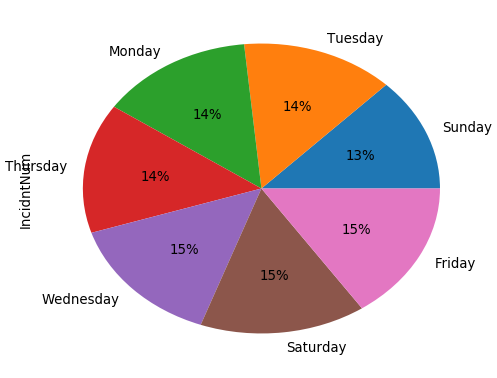

In [7]:
display(dfIncidents)

# More data Exploration and Hypothesis
As we have just seen, we can quickly identify a couple of areas of interest in our data without having to write a single line of code:

1) Most incidents happen in the Southern  police district, and

2) The number of incidents is approximately the same for each day, ranging from 13-15% of the total per day.

When looking at the table voew, we also realized that our data needs some cleansing if we want to make analysis easier. Specifically:

- The `Time` field is a string, so we'll need to add an `Hour` column if we want to see the time of day when most incidents occur, and
- The `DayOfWeek` values are rendered in alphabetical order by default instead of chronological order, so we should rename them to make it easier to see how the number of incidents changes over the course of the week
- And we should condense the outcome types of each police incident if we want to see the most common resolutions of police incidents in each police district, since the clustering above was undifferentiating. We will create a calculated column `Res` 

Let's cleanse the data using Spark DataFrame code and re-investigate before moving on:

> Note: the next cell is using PySpark APIs to manipulate the data. You can find more information on these APIs [here](http://spark.apache.org/docs/1.6.0/api/python/pyspark.sql.html)

In [10]:
from pyspark.sql.functions import udf
from pyspark.sql.types import *

# Rename weekdays to sorted names in order to enable mini time-series analysis
dfIncidents = dfIncidents.na.replace\
    (['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],\
    ['1-Mon','2-Tues','3-Wed','4-Thur','5-Fri','6-Sat','7-Sun'],\
    'DayOfWeek')

# Get the hour value of a time string, e.g. getHour("05:30") will yield the integer value 5
def getHour(s):
    return int(s.split(':')[0])
# We use this python function to define a user-defined-function that can be executed in the Spark cluster
hr_udf = udf(getHour,IntegerType())

# Add Hour column and refine outcomes from police incidents using the UDF
dfIncidents = dfIncidents.withColumn("Hour",hr_udf(dfIncidents['Time']));

# Similarly, use a udf  to coalesce incident resolution as `Arrest`, `No Resolution`  or `Other`
dfIncidents = dfIncidents.withColumn("Res",udf(lambda x: 'Arrest' if 'ARREST' in x else 'No Resolution' if x == 'NONE' else 'Other',StringType())(dfIncidents['Resolution']))

### We are now ready for more data exploration

Run the cell below which operates on the augmented dataframe

1. Hypothesis: Do incidents in one police district result in more arrests than other police districts?
    * To find out, run the cell below and set the following display options:
    * Bar Chart
    * _Options_: `Keys = PdDistrict`, `Values = IncidntNum`, `Aggregation = Count`, `Cluster By: Res`
    * The districts where there are more arrests than no resolution stand out (`Richmnond`, `Mission`, ...)
    I find the `horizontal` orientation better for showing the Police Districts.

2. Question: How does the number of incidents change over the course of the week?
    * To answer, change the options to 
    * Line Chart
    * _Options: `Keys = DayOfWeek`, `Values = IncidntNum`, `Aggregation = Count`,  `Cluster By: None`
    * We now see a slow increase to a slight peak on Fridays, with a decrease until Sundays



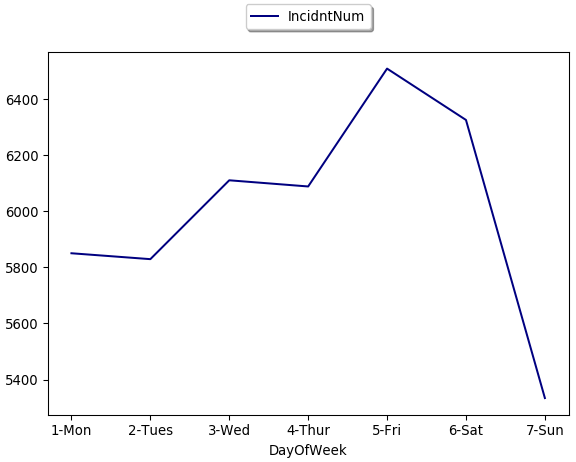

In [11]:
display(dfIncidents)

In [15]:
dfIncidents.dtypes

[('IncidntNum', 'int'),
 ('Category', 'string'),
 ('Descript', 'string'),
 ('DayOfWeek', 'string'),
 ('Date', 'string'),
 ('Time', 'string'),
 ('PdDistrict', 'string'),
 ('Resolution', 'string'),
 ('Address', 'string'),
 ('X', 'double'),
 ('Y', 'double'),
 ('Location', 'string'),
 ('PdId', 'bigint'),
 ('Hour', 'int'),
 ('Res', 'string')]

## What have we learned
A few lines of code makes it a lot easier to see that:

1) Incidents in the Mission and Southern police districts are much more likely to result in arrest than all other districts, and

2) The number of incidents raises slightly during the middle of the week, through Friday, and then decreases through Sunday.

## Now let's focus on the Mission police district using some friendly SQL notation
PySpark and SparkSQL allow for high-level SQL-like queries to run on Spark DataFrames.   
We use this here to create a new `dfMission` dataframe which has only Mission PdDistrict

In [16]:
dfIncidents.registerTempTable("incidents")
dfMission = sqlContext.sql("SELECT * FROM incidents WHERE PdDistrict='MISSION'")

### Run the cell below to display a Mission-focused map
We are now able to drill down deeper in the structure of `Mission` incidents
1. Question: Where in Mission do most incidents happen?
   * Select `Map` as type (we have x,y coordinates for incidents locations)
   * Set Options to  `Keys = [X,Y]`, `Values = IncidntNum`, `Aggregation = Count`
   * Set the Renderer to `mapbox`, kind: `density-map`
   * It appears that incidents are distributed with a predominance along the district's central street 'Mission St', with a predominance on main streets and avenues.

2. Question: What time of day do most incidents occur?
   * select type back to `Line Chart`
   * Set Options: `Keys = Hour`, `Values = IncidntNum`, `Aggregation = Count`
   * Two spikes of incidents clearly matches noon and evening



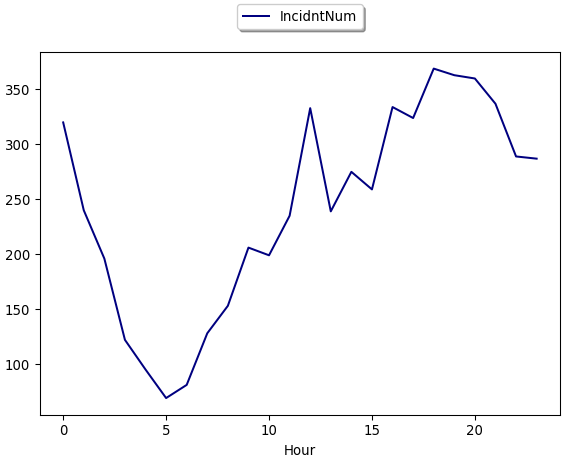

In [17]:
display(dfMission)

## What have we learned:
Most of the results from looking at the incident times are unsurprising:

- Number of incidents drop sharply very early morning (people probably sleeping),
- Steady increase in number of incidents until noon,
- Fairly high numbers from 3:00 PM until 8:00 PM,
- Surprisingly, incidents decline after 8:00PM.

The interesting thing here is the fact that the peaks are at noon and from 3:00PM until 8:00 PM, as one might expect the later evening times to be more problematic.


This concludes the pixiedust lab. In the nextlab, we will se Watson Studio can be used to build dashboards